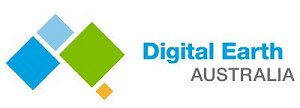

## Validation Notebook  : Process ASD Radiance Data


***************************************************************************************************


Description :  This notebook imports individual ASD radiance field data and plots computes reflectances, and uses a weighted mean to resample the data to OLI or Sentinel band widths. 

(Note : These steps will disabled for development  ...  will be using the acqisition date and location it extracts point relectance values from the best case NBART epoch - and compares the spectra.)  

       
Created : Based on DEA Gunning (December 2017) Modified March 2018  
Author  :  G Byrne (et al)

Inputs : ASD spectral files (*.sco) - extracts spectra and the meta data (site, description, date, lat, long and utc time)

Dependancies: Dave Gavin (Cube_query tools)
              Emma Ai's (weighted mean spectral resampling functions)  

***************************************************************************************************

In [1]:
import csv, glob, sys, os, re
from os import listdir
import numpy as np
import pandas as pd
# from collections import defaultdict 

%pylab notebook
import datacube
from datetime import datetime, timedelta
import pyproj
from pandas import Series

dc = datacube.Datacube(app='nbart-fieldsites')

Populating the interactive namespace from numpy and matplotlib


### Define source directories and site name

NEED TO ITERATE OVER ALL THE LINES

In [2]:
# manually edit paths and site name and suffix

home = '/g/data1a/u46/users/aw3463/GuyByrne/30APR18/lake_george/26_march_2018/line1/' # input file
output = '/g/data1a/u46/users/aw3463/GuyByrne/30APR18/graphics/'
field_site = 'Lake George'
panel_dir =  '/g/data1a/u46/users/aw3463/GuyByrne/30APR18/lake_george/26_march_2018/'
in_panel = 'ga_panel1_jan_2018.txt'
suffix = 'asd.rad.txt'
# num_lines = 
# transects = ['line1','line2','line3','line4','line5','line6','line7','line8','line9','line10']

### Define which line to process

In [3]:
# this is not yet needed
#line = transects[0] + '/'
#line

In [4]:
spectra = []
for root, dirs, files in sorted(os.walk(home)):
    for file in files:
        if file.endswith(suffix):
                spectra.append(file)
spectra = sorted(spectra)

In [5]:
# create list input files - pandas column names
col_nams = []
for root, dirs, files in os.walk(home):
    for file in files:
        if file.endswith(suffix):
                tmp = file[:-12] 
                col_nams.append(tmp)
col_nams = sorted(col_nams)
#col_nams

### Open panel k-factor

In [6]:
k_f = pd.read_csv(panel_dir + in_panel, skiprows=5, delim_whitespace=True)

k_f.set_index("Wavelength", inplace = True) # sets index to wavelength
k_f

,K-factor
Wavelength,
350,0.913720
351,0.914872
352,0.916023
353,0.917174
354,0.918323
355,0.919469
356,0.920612
357,0.921751
358,0.922886


### Creates Dictionary, and keys with empty lists

In [7]:
# Meta data lists

meta_keys = ['site','descr','date','latitude','longitude','utc']

#kiril's empty list for each key

{k:[] for k in meta_keys}

# initialise dictionary

dictionary= {k:[] for k in meta_keys}

### Steps through the input files and reads spectral data into a pandas file

In [8]:
count = len(spectra) - 1

print(count)

for i in range (0, len(spectra)):
    infile = spectra[i]
    if i == 0: 
        df = pd.read_csv(home + infile, skiprows=38, delim_whitespace=True) 
    else:
        tmpDF = pd.read_csv(home + infile, skiprows=38, delim_whitespace=True)
        df = df.merge(tmpDF)              
df

37


,Wavelength,llg_l100000.asd.rad,llg_l100001.asd.rad,llg_l100002.asd.rad,llg_l100003.asd.rad,llg_l100004.asd.rad,llg_l100005.asd.rad,llg_l100006.asd.rad,llg_l100007.asd.rad,llg_l100008.asd.rad,...,llg_l100028.asd.rad,llg_l100029.asd.rad,llg_l100030.asd.rad,llg_l100031.asd.rad,llg_l100032.asd.rad,llg_l100033.asd.rad,llg_l100034.asd.rad,llg_l100035.asd.rad,llg_l100036.asd.rad,llg_l100037.asd.rad
0,350,0.125462,0.125446,0.004827,0.004636,0.005039,0.004800,0.004970,0.004882,0.005296,...,0.004328,0.004639,0.004612,0.004523,0.004653,0.004240,0.125199,0.125193,0.125266,0.125209
1,351,0.126320,0.126320,0.004923,0.004693,0.005126,0.004840,0.005019,0.004944,0.005337,...,0.004370,0.004705,0.004693,0.004581,0.004727,0.004276,0.126054,0.126034,0.126132,0.126069
2,352,0.126721,0.126695,0.004974,0.004716,0.005168,0.004910,0.005064,0.004988,0.005404,...,0.004433,0.004756,0.004736,0.004626,0.004755,0.004336,0.126441,0.126402,0.126493,0.126473
3,353,0.128194,0.128162,0.005059,0.004806,0.005255,0.005008,0.005151,0.005077,0.005501,...,0.004533,0.004842,0.004819,0.004715,0.004827,0.004398,0.127882,0.127859,0.127945,0.127949
4,354,0.129476,0.129450,0.005121,0.004885,0.005324,0.005072,0.005220,0.005152,0.005570,...,0.004593,0.004901,0.004881,0.004772,0.004898,0.004443,0.129133,0.129135,0.129215,0.129220
5,355,0.129524,0.129494,0.005123,0.004889,0.005333,0.005075,0.005229,0.005167,0.005581,...,0.004572,0.004893,0.004882,0.004752,0.004916,0.004472,0.129163,0.129173,0.129236,0.129238
6,356,0.130862,0.130838,0.005209,0.004962,0.005454,0.005144,0.005322,0.005254,0.005671,...,0.004647,0.004972,0.004977,0.004839,0.004971,0.004537,0.130475,0.130518,0.130577,0.130578
7,357,0.132197,0.132190,0.005301,0.005055,0.005554,0.005255,0.005418,0.005357,0.005787,...,0.004766,0.005079,0.005081,0.004935,0.005083,0.004641,0.131842,0.131886,0.131945,0.131950
8,358,0.133838,0.133834,0.005404,0.005156,0.005643,0.005373,0.005525,0.005458,0.005905,...,0.004875,0.005195,0.005172,0.005031,0.005206,0.004750,0.133514,0.133544,0.133612,0.133619
9,359,0.136318,0.136283,0.005536,0.005267,0.005772,0.005475,0.005665,0.005555,0.006020,...,0.004945,0.005309,0.005260,0.005145,0.005284,0.004830,0.135947,0.135983,0.136076,0.136077


### Plot field spectra

In [9]:
# print the field spectra at full resolution
jstest = df.copy()

# set index is replacing the pandas data frame native index with the spectum wl
jstest.set_index('Wavelength', inplace=True)

<IPython.core.display.Javascript object>


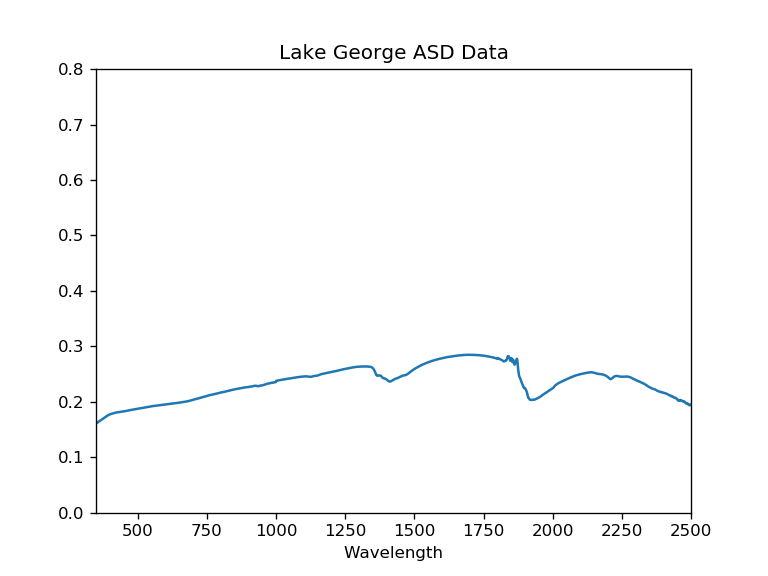

In [23]:
# plot is the inbuilt pandas function
# Plot of the all the ASD data t full resolution 

jstest[1:2500].plot(title = "Lake George ASD Data", xlim=(350,2500), ylim=(0,0.8), legend=False)


### Identify the Panel readings

In [11]:
panels = []
for column in df.columns[1:]:  # skips the fist column
    if (df[column].iloc[1] > 0.10000):
        panels.append(column)
panels
#temp

['llg_l100000.asd.rad',
 'llg_l100001.asd.rad',
 'llg_l100034.asd.rad',
 'llg_l100035.asd.rad',
 'llg_l100036.asd.rad',
 'llg_l100037.asd.rad']

In [12]:
new = df.filter([panels[0],panels[1],panels[2],panels[3]], axis = 1)
xbar = new.mean(axis=1)
waves = df['Wavelength'] # single column of wavelegths
xbar.columns = ['xbar'] 
result = pd.concat([waves, xbar], axis = 1)
result.set_index("Wavelength", inplace = True) # sets the df index to wavelenth
result

,0
Wavelength,
350,0.125325
351,0.126182
352,0.126565
353,0.128024
354,0.129299
355,0.129338
356,0.130674
357,0.132029
358,0.133682


<IPython.core.display.Javascript object>


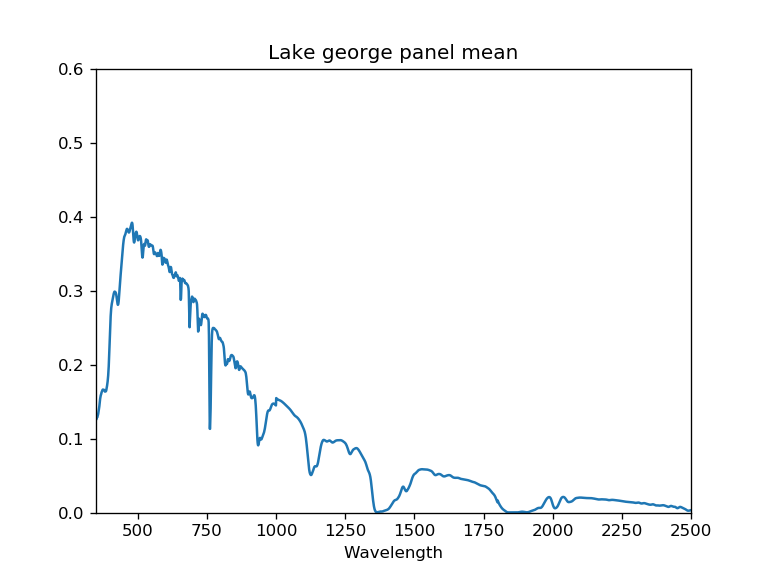

In [24]:
# plot is the inbuilt pandas function
# Plot of the all the ASD data t full resolution 
# print the field spectra at full resolution


jstest = result.copy()

# set index is replacing the pandas data frame native index with the spectum wl
#jstest.set_index('Wavelength', inplace=True)


jstest[1:2500].plot(title = "Lake george panel mean", xlim=(350,2500), ylim=(0,0.6), legend=False)

### Create Reflectances 

In [14]:
temp = df # copies the dataframe 
# len(test.columns)
radiances = temp.drop(temp.columns[[0,1,28,29]], axis = 1) # deletes the refl panel columns

xbar_rads = radiances.mean(axis=1)
xbar_radiances = pd.concat([waves, xbar_rads], axis = 1)  # adds wavelengths 
xbar_radiances.set_index("Wavelength", inplace = True) # sets the df index to wavelenth
#xbar_radiances
refl_tmp = xbar_radiances.div(result)  
#refl_tmp
line_refls = refl_tmp * k_f.values
line_refls

,0
Wavelength,
350,0.160570
351,0.160950
352,0.161381
353,0.161777
354,0.162065
355,0.162267
356,0.162676
357,0.163216
358,0.163674


<IPython.core.display.Javascript object>


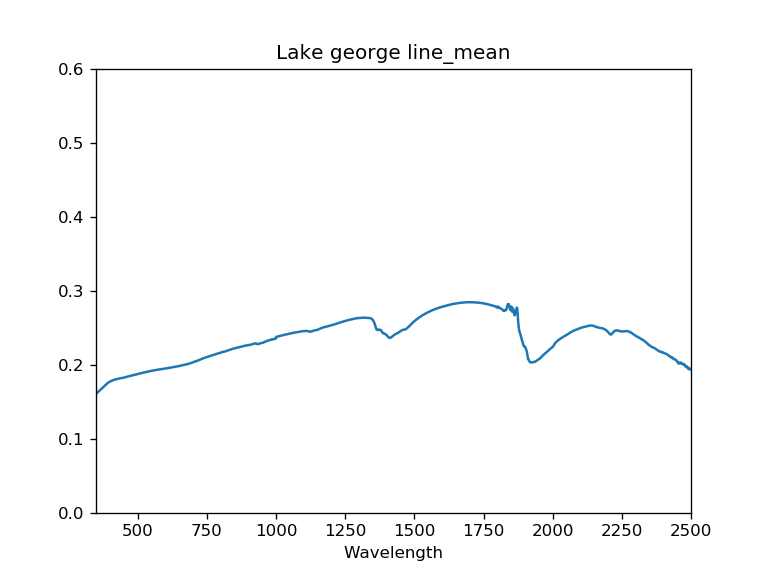

In [25]:
jstest = line_refls.copy()

# set index is replacing the pandas data frame native index with the spectum wl
#jstest.set_index('Wavelength', inplace=True)


jstest[1:2500].plot(title = "Lake george line_mean", xlim=(350,2500), ylim=(0,0.6), legend=False)

## Simulate the landsat band centres ...  ETM7 and ETM8 

In [16]:
# Atmospheric absortion wl 
# 1349 - 1408,  1801 - 1966,  2350 - 2500

# averages the wavelengths down the columns (axis = 0)

LS8B2 = (line_refls[0].iloc[102:163].mean(axis=0))
LS8B3 = (line_refls[0].iloc[183:241].mean(axis=0))
LS8B4 = (line_refls[0].iloc[286:324].mean(axis=0))
LS8B5 = (line_refls[0].iloc[502:530].mean(axis=0))
LS8B6 = (line_refls[0].iloc[1216:1302].mean(axis=0))
LS8B7 = (line_refls[0].iloc[1757:1945].mean(axis=0))

LS8_Bnds = [LS8B2, LS8B3, LS8B4, LS8B5, LS8B6, LS8B7]

print('Landsat 8 band centres (int) :', LS8_Bnds)

#Simulated Landsat 8 bands (int): [482.0, 561.5, 654.5, 865.5, 1608.5, 2200.5]


LS7B1 = (line_refls[0].iloc[100:170].mean(axis=0))
LS7B2 = (line_refls[0].iloc[170:250].mean(axis=0))
LS7B3 = (line_refls[0].iloc[280:340].mean(axis=0))
LS7B4 = (line_refls[0].iloc[420:550].mean(axis=0))
LS7B5 = (line_refls[0].iloc[1200:1400].mean(axis=0))
LS7B7 = (line_refls[0].iloc[1659:1999].mean(axis=0))

LS7_Bnds = [LS7B1, LS7B2, LS7B3,LS7B4,LS7B5,LS7B7]

print('Landsat 7 band centres (int) :', LS7_Bnds)

#Simulated Landsat 7 bands (int): [482.0, 561.5, 654.5, 865.5, 1608.5, 2200.5]


Landsat 8 band centres (int) : [0.1857164390966699, 0.19255582262743992, 0.19868784082086688, 0.22382220935454725, 0.2791621481004475, 0.24748859497598094]
Landsat 7 band centres (int) : [0.18595120900739634, 0.19234488135448663, 0.19914154908410936, 0.22024490915598866, 0.28108682332408014, 0.24368074436339443]


###  create case test for different LTM's

In [17]:
'''# Build case function to test which landsat

if platform='ls7' then:
    for column in df:
    LS7_rB1 = df[column].iloc[100:170].mean(axis=0)
    LS7_rB2 = df[column].iloc[170:250].mean(axis=0)
    LS7_rB3 = df[column].iloc[280:340].mean(axis=0)
    LS7_rB4 = df[column].iloc[420:550].mean(axis=0)
    LS7_rB5 = df[column].iloc[1200:1400].mean(axis=0)
    LS7_rB7 = df[column].iloc[1659:1999].mean(axis=0)
   
    col_tmp = [LS7_rB1, LS7_rB2, LS7_rB3, LS7_rB4, LS7_rB5, LS7_rB7]
    xbars.append(col_tmp) 
    resm_field_spec_df = pd.DataFrame(xbars, columns=["B1","B2","B3","B4","B5","B7"])

if platform = ls8 then:
    for column in df:
    LS8_rB2 = df[column].iloc[102:163].mean(axis=0)
    LS8_rB3 = df[column].iloc[183:241].mean(axis=0)
    LS8_rB4 = df[column].iloc[286:324].mean(axis=0)
    LS8_rB5 = df[column].iloc[502:530].mean(axis=0)
    LS8_rB6 = df[column].iloc[1216:1302].mean(axis=0)
    LS8_rB7 = df[column].iloc[1757:1949].mean(axis=0)
   
    col_tmp = [LS8_rB2, LS8_rB3, LS8_rB4, LS8_rB5, LS8_rB6, LS8_rB7]    
    xbars.append(col_tmp)    
   

resm_field_spec_df = pd.DataFrame(xbars, columns=["B2","B3","B4","B5","B6","B7"])
    
# resm_field_spec_df'''

'# Build case function to test which landsat\n\nif platform=\'ls7\' then:\n    for column in df:\n    LS7_rB1 = df[column].iloc[100:170].mean(axis=0)\n    LS7_rB2 = df[column].iloc[170:250].mean(axis=0)\n    LS7_rB3 = df[column].iloc[280:340].mean(axis=0)\n    LS7_rB4 = df[column].iloc[420:550].mean(axis=0)\n    LS7_rB5 = df[column].iloc[1200:1400].mean(axis=0)\n    LS7_rB7 = df[column].iloc[1659:1999].mean(axis=0)\n   \n    col_tmp = [LS7_rB1, LS7_rB2, LS7_rB3, LS7_rB4, LS7_rB5, LS7_rB7]\n    xbars.append(col_tmp) \n    resm_field_spec_df = pd.DataFrame(xbars, columns=["B1","B2","B3","B4","B5","B7"])\n\nif platform = ls8 then:\n    for column in df:\n    LS8_rB2 = df[column].iloc[102:163].mean(axis=0)\n    LS8_rB3 = df[column].iloc[183:241].mean(axis=0)\n    LS8_rB4 = df[column].iloc[286:324].mean(axis=0)\n    LS8_rB5 = df[column].iloc[502:530].mean(axis=0)\n    LS8_rB6 = df[column].iloc[1216:1302].mean(axis=0)\n    LS8_rB7 = df[column].iloc[1757:1949].mean(axis=0)\n   \n    col_tmp =

### Resamples FIELD spectra to landsat band centres ... ETM7 and ETM8

In [18]:
# creates x-bars DF with;

# row 0 = simulated
# row 0 = simulated als 8 band centres
# r 1 - n = the field spectra 

ls7_xbars = []
ls8_xbars = []



# ETM7

for column in df:
    LS7_rB1 = df[column].iloc[100:170].mean(axis=0)
    LS7_rB2 = df[column].iloc[170:250].mean(axis=0)
    LS7_rB3 = df[column].iloc[280:340].mean(axis=0)
    LS7_rB4 = df[column].iloc[420:550].mean(axis=0)
    LS7_rB5 = df[column].iloc[1200:1400].mean(axis=0)
    LS7_rB7 = df[column].iloc[1659:1999].mean(axis=0)
   
    ls7_col_tmp = [LS7_rB1, LS7_rB2, LS7_rB3, LS7_rB4, LS7_rB5, LS7_rB7]
  
    ls7_xbars.append(ls7_col_tmp)    
   
ls7_resm_field_spec_df = pd.DataFrame(ls7_xbars, columns=["B1","B2","B3","B4","B5","B7"])
    
ls7_resm_field_spec_df

# strips out the first row with simulated LTM wavlengths 

ls7_wvl_df = ls7_resm_field_spec_df.iloc[0]

# makes new df with only site resm site reflectances 

ls7_resm_field_spec_no_wl = ls7_resm_field_spec_df.iloc[1:]
ls7_resm_field_spec_no_wl

    
    
#    ETM8
    
for column in df:
    LS8_rB2 = df[column].iloc[102:163].mean(axis=0)
    LS8_rB3 = df[column].iloc[183:241].mean(axis=0)
    LS8_rB4 = df[column].iloc[286:324].mean(axis=0)
    LS8_rB5 = df[column].iloc[502:530].mean(axis=0)
    LS8_rB6 = df[column].iloc[1216:1302].mean(axis=0)
    LS8_rB7 = df[column].iloc[1757:1949].mean(axis=0)
   
    ls8_col_tmp = [LS8_rB2, LS8_rB3, LS8_rB4, LS8_rB5, LS8_rB6, LS8_rB7]    
   
    ls8_xbars.append(ls8_col_tmp)    
   
ls8_resm_field_spec_df = pd.DataFrame(ls8_xbars, columns=["B2","B3","B4","B5","B6","B7"])
 
# ls8_resm_field_spec_df

# strips out the first row with simulated LTM wavlengths 
ls8_wvl_df = ls8_resm_field_spec_df.iloc[0]

# makes new df with only site resm site reflectances 
ls8_resm_field_spec_no_wl = ls8_resm_field_spec_df.iloc[1:]
# ls8_resm_field_spec_no_wl

### Reads each spectral file and writes metadata (description, date, lat, long, utc time) to the dictionary

In [19]:
for filename in os.listdir(home):
    if filename.endswith(suffix):
        file_nos = filename[:-8]  # strips the '.sco.txt'
        dictionary['site'].append(field_site)
        file_handle = open(home + filename, 'r')
        for i, line in enumerate(file_handle):
            if i == 3:
                tmp_descr = line.rstrip('\x00\n')
                dictionary['descr'].append(tmp_descr)
            if i == 6:
                tmp_date = line.rstrip('\n')
                dictionary['date'].append(tmp_date)
            if i == 26:
                tmp_lat = line.rstrip('\n')
                dictionary['latitude'].append(tmp_lat)
            if i == 27:
                tmp_long = line.rstrip('\n')
                dictionary['longitude'].append(tmp_long)
            if i == 29:
                tmp_utc = line.rstrip('\n') 
                dictionary['utc'].append(tmp_utc)
                
# print('meta_keys = ', meta_keys)
print('The final dictionary =', dictionary)

The final dictionary = {'site': ['Lake George', 'Lake George', 'Lake George', 'Lake George', 'Lake George', 'Lake George', 'Lake George', 'Lake George', 'Lake George', 'Lake George', 'Lake George', 'Lake George', 'Lake George', 'Lake George', 'Lake George', 'Lake George', 'Lake George', 'Lake George', 'Lake George', 'Lake George', 'Lake George', 'Lake George', 'Lake George', 'Lake George', 'Lake George', 'Lake George', 'Lake George', 'Lake George', 'Lake George', 'Lake George', 'Lake George', 'Lake George', 'Lake George', 'Lake George', 'Lake George', 'Lake George', 'Lake George', 'Lake George'], 'descr': ['line1', 'line1', 'line1', 'line1', 'line1', 'line1', 'line1', 'line1', 'line1', 'line1', 'line1', 'line1', 'line1', 'line1', 'line1', 'line1', 'line1', 'line1', 'line1', 'line1', 'line1', 'line1', 'line1', 'line1', 'line1', 'line1', 'line1', 'line1', 'line1', 'line1', 'line1', 'line1', 'line1', 'line1', 'line1', 'line1', 'line1', 'line1'], 'date': ['Spectrum saved: 03/26/2018 at 00:

### Create standalone lists

In [20]:
descr = []
date = []
lat = []
long = []
utc = []

#print (meta_keys[2])

### Extracts metadata lists from dictionary and creates standalone lists  

In [50]:
for key in meta_keys:
   my_list = dictionary.get(key) # extract the list.
   
    # print("list for ",key,my_list) 
   
   for i in range(0,len(my_list)): 
  
    # print ("item",i,"in",key,":",my_list[i])
    # write individual lists 
    
      if key == meta_keys[1]:
        descr.append(my_list[i])
      elif key == meta_keys[2]:
        date.append(my_list[i])
      elif key == meta_keys[3]:
        lat.append(my_list[i])
      elif key == meta_keys[4]:
        long.append(my_list[i])
      elif key == meta_keys[5]:
        utc.append(my_list[i])
        
      #print ("item",i," in ",my_list,": ",my_list(i))
     
# print("\n")  # create blank line in printout

### Extract coords and reformat (DM.m to D.d)  - write site coordinate pairs

In [34]:
def dmin_2_ddeg(decmn):
    decimal = int(decmn/60)
    return (str(decimal))

def single_loc(index):
    y = (lat[index][17:30])
    x = (long[index][19:30])
    lat_prefix = y.replace('.','')
    long_prefix = x.replace('.','')
    y_pref = (lat_prefix[0:3])
    y_suff = (int(lat_prefix[3:10]))
    dy_suff = (dmin_2_ddeg(y_suff))
    lat_pnt = (y_pref + '.' + dy_suff)
    x_pref = (long_prefix[0:3])
    x_suff = (int(long_prefix[3:9]))
    dx_suff = (dmin_2_ddeg(x_suff))
    lon_pnt = (x_pref + '.' + dx_suff)
    point = lat_pnt + ',' + lon_pnt
    point = (lon_pnt + ',' + lat_pnt)
    print('new point =', point)
    return point

dec_lat = [[]] * len(lat)
dec_long = [[]] * len(lat)

for n in range(0,len(lat)):
        line = (single_loc(n))
        tlong,tlat=line.split(',')
        dec_long[n] = float(tlong)
        dec_lat[n] = float(tlat)
       
# print('lat =', dec_lat, 'long = ', dec_long)

ValueError: invalid literal for int() with base 10: ''

### Extract site description 

In [35]:
def description(index):
    d = (descr[i])
    re.sub(r'\W+','', d)
    return d

descrips = [[]] * len(descr)

for i in range(0, len(descr)):
    descr_line = description(i)
    descrips[i] = descr_line
    
# print(descrips)

### Extract and reformat sampling dates 

In [36]:
def dates(index):
    desc = (date[index][16:26])
    m,d,y = desc.split('/')
    ok_date = y + '-' +  m  +'-' + d
    return ok_date

field_dates = [[]] * len(descr)

for i in range(0, len(date)):
    site_date = dates(i)
    field_dates[i] = site_date
        
# print(field_dates)

### Create dataframe as input for cube query csv 

In [37]:
# NB this dictionary - needs to be coded to accept 'n' site_nos 

def insert_dic(name,index):
    daves_df[name].append(name[index])

site_num = 1
    

daves_df = {'site_nos': [site_num],
       'date': [field_dates[0]],
       'lon': [dec_long[0]],
       'lat': [dec_lat[0]],
       'descr': [descrips[0]]}

# daves_df

for i in range (1, len(spectra)):
    site_num += 1
    daves_df["site_nos"].append(site_num)
    daves_df["date"].append(field_dates[i])
    daves_df["lon"].append(dec_long[i])
    daves_df["lat"].append(dec_lat[i])
    daves_df["descr"].append(descr[i])                           
                               
                                                  
d_df = pd.DataFrame(daves_df)
# d_df.sort_index(axis=0,ascending=False)

# d_df

### write asd field sites to text file 

In [38]:
d_df.to_csv(home + 'gunning_asdfr_sites.txt', header=None, index=None, sep=' ', mode='w')

In [39]:
%matplotlib inline
import matplotlib.pyplot as plt

### Field spectra at full resolution


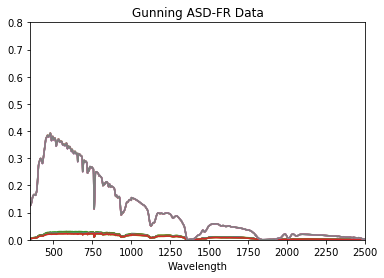

In [40]:
# print the field spectra at full resolution
jstest = df.copy()

# set index is replacing the pandas data frame native index with the spectum wl
jstest.set_index('Wavelength', inplace=True)
# plot is the inbuilt pandas function
# Plot of the all the ASD data t full resolution 

jstest[1:2500].plot(title = "Gunning ASD-FR Data", xlim=(350,2500), ylim=(0,0.8), legend=False)

## Extract NBART epoch and point data 

In [41]:
# Josh's pandas to csv .. 

tmp_fieldsites = daves_df

# print(tmp_fieldsites)

tmp = pd.DataFrame(tmp_fieldsites)

tmp.to_csv('tmp.csv', columns=['site_no','date', 'lon', 'lat', 'descr'], index = False)

#for i, row in tmp.iterrows():
 #   print(i, row.site_nos, row.date, row.lon, row.lat, row.descr)   

/g/data/v10/public/modules/dea-env/20180405/lib/python3.6/site-packages/pandas/io/formats/format.py:1586: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  self.obj = self.obj.loc[:, cols]
/g/data/v10/public/modules/dea-env/20180405/lib/python3.6/site-packages/pandas/core/indexing.py:1367: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


In [42]:
fieldsites = pd.read_csv(
    'tmp.csv',
    names=[
        'site_nos',
        'date',
        'lon',
        'lat',
        'descr'
    ], skiprows = [0])
# fieldsites

### Dave Gavin's query cube function - nbar

In [43]:
def query_cube(fieldsite_key, fieldsite_time, lon, lat):
    target_day = datetime.strptime(fieldsite_time, '%Y-%m-%d')
    time_before = (target_day - timedelta(days=60)).strftime('%Y-%m-%d')
    time_after = (target_day + timedelta(days=60)).strftime('%Y-%m-%d')
    
    query = {'time': (time_before, time_after)}
    
    wgs_84 = pyproj.Proj(init='epsg:4326')
    aus_albers = pyproj.Proj(init='epsg:3577')

    x, y = pyproj.transform(wgs_84, aus_albers, lon, lat)
    
    y_max = y-30
    y_min = y+30
    x_max = x-30
    x_min = x+30
    query['x'] = (x_min, x_max)
    query['y'] = (y_max, y_min)
    query['crs'] = 'EPSG:3577'
        
    query['output_crs'] = 'EPSG:3577'
    query['resolution'] = -25, 25
    
    query['measurements'] = ['blue',
                          'green',
                          'red', 
                          'nir',
                          'swir1', 
                          'swir2'
                          ]
    
    deltas = {}
    products = dc.list_products()
    delta = None
    observation_date = None
    observation_product = None
    for product in products.name:        
        #if(product.startswith('ls') and product.endswith('albers') and (product not in ['ls5_ndvi_albers','ls7_ndvi_albers','ls8_ndvi_albers'])):
        if(product in ['ls5_nbar_albers','ls7_nbar_albers','ls8_nbar_albers']):        
            datasets = dc.find_datasets(product=product,**query)
            for dataset in datasets:
                if(delta == None):
                    delta  = (target_day - dataset.center_time)
                    observation_date = dataset.center_time
                    observation_product = product
                    continue
                current_delta = (target_day - dataset.center_time)
                if(abs(current_delta) < abs(delta)):
                    delta  = current_delta
                    observation_date = dataset.center_time
                    observation_product = product
    if(observation_date):
        time_before = (observation_date - timedelta(days=1)).strftime('%Y-%m-%d')
        time_after = (observation_date + timedelta(days=1)).strftime('%Y-%m-%d')
        query['time'] = (time_before, time_after)
        data = dc.load(product=observation_product, **query)

        point = data.sel(x=x,y=y,time=target_day, method='nearest')
        blue = point.blue.data
        green = point.green.data
        red = point.red.data
        nir = point.nir.data
        swir1 = point.swir1.data
        swir2 = point.swir2.data

        return fieldsite_key, fieldsite_time, lon, lat, observation_product, observation_date, delta, blue, green, red, nir, swir1, swir2
    else:
        print('could not find: ' + fieldsite_time)
        return None

In [48]:
 [tuple(x) for x in fieldsites.values]

[(nan, '2018-03-26', '[]', '[]', 'line1'),
 (nan, '2018-03-26', '[]', '[]', 'line1'),
 (nan, '2018-03-26', '[]', '[]', 'line1'),
 (nan, '2018-03-26', '[]', '[]', 'line1'),
 (nan, '2018-03-26', '[]', '[]', 'line1'),
 (nan, '2018-03-26', '[]', '[]', 'line1'),
 (nan, '2018-03-26', '[]', '[]', 'line1'),
 (nan, '2018-03-26', '[]', '[]', 'line1'),
 (nan, '2018-03-26', '[]', '[]', 'line1'),
 (nan, '2018-03-26', '[]', '[]', 'line1'),
 (nan, '2018-03-26', '[]', '[]', 'line1'),
 (nan, '2018-03-26', '[]', '[]', 'line1'),
 (nan, '2018-03-26', '[]', '[]', 'line1'),
 (nan, '2018-03-26', '[]', '[]', 'line1'),
 (nan, '2018-03-26', '[]', '[]', 'line1'),
 (nan, '2018-03-26', '[]', '[]', 'line1'),
 (nan, '2018-03-26', '[]', '[]', 'line1'),
 (nan, '2018-03-26', '[]', '[]', 'line1'),
 (nan, '2018-03-26', '[]', '[]', 'line1'),
 (nan, '2018-03-26', '[]', '[]', 'line1'),
 (nan, '2018-03-26', '[]', '[]', 'line1'),
 (nan, '2018-03-26', '[]', '[]', 'line1'),
 (nan, '2018-03-26', '[]', '[]', 'line1'),
 (nan, '201

In [47]:
fieldsites.values

array([[nan, '2018-03-26', '[]', '[]', 'line1'],
       [nan, '2018-03-26', '[]', '[]', 'line1'],
       [nan, '2018-03-26', '[]', '[]', 'line1'],
       [nan, '2018-03-26', '[]', '[]', 'line1'],
       [nan, '2018-03-26', '[]', '[]', 'line1'],
       [nan, '2018-03-26', '[]', '[]', 'line1'],
       [nan, '2018-03-26', '[]', '[]', 'line1'],
       [nan, '2018-03-26', '[]', '[]', 'line1'],
       [nan, '2018-03-26', '[]', '[]', 'line1'],
       [nan, '2018-03-26', '[]', '[]', 'line1'],
       [nan, '2018-03-26', '[]', '[]', 'line1'],
       [nan, '2018-03-26', '[]', '[]', 'line1'],
       [nan, '2018-03-26', '[]', '[]', 'line1'],
       [nan, '2018-03-26', '[]', '[]', 'line1'],
       [nan, '2018-03-26', '[]', '[]', 'line1'],
       [nan, '2018-03-26', '[]', '[]', 'line1'],
       [nan, '2018-03-26', '[]', '[]', 'line1'],
       [nan, '2018-03-26', '[]', '[]', 'line1'],
       [nan, '2018-03-26', '[]', '[]', 'line1'],
       [nan, '2018-03-26', '[]', '[]', 'line1'],
       [nan, '2018-0

In [46]:
fieldsite_tuples = [tuple(x) for x in fieldsites.values]
index = 0
observation_tuples = []
for fieldsite in fieldsite_tuples: 
    #result = query_cube(*fieldsite)
    result = query_cube(fieldsite_key=fieldsite[0],fieldsite_time=fieldsite[1], lon=fieldsite[2], lat=fieldsite[3])
    if(result):
        observation_tuples.append(result)
    index = index + 1
    if(index >= 500):
        break

TypeError: input must be an array, list, tuple or scalar

In [ ]:
#observation_tuples

In [ ]:
nbar_df = pd.DataFrame(observation_tuples,
                  columns=[
                      'Site_No',
                      'Date',
                      'Long',
                      'Lat',
                      'Observation_product',
                      'Observation_date',
                      'Time_delta',
                      'Blue',
                      'Green',
                      'Red',
                      'NIR',
                      'SWIR_1',
                      'SWIR_2'
                  ])

In [ ]:
fieldsites.values
nbar_df
nbar_df.to_csv(home + 'gunning_nbar_sites.txt', header=None, index=None, sep=' ', mode='w')


### Edit Field sites based on duplicate pixels 

### 2nd Run - Average ASD spectra for each field site based on replicate nbar pixels - edit manually

.. need to improve this!


In [ ]:
# resm_field_spec_df = pd.DataFrame(xbars, columns=["B2","B3","B4","B5","B6","B7"])
    
# df = pd.DataFrame(data=[[1,2,3]]*5, index=range(3, 8), columns = ['a','b','c'])

# LANDSAT 7 BAND NAMES
# asd_site1_mns = ls7_resm_field_spec_no_wl[["B2","B3","B4","B5","B6","B7"]].iloc[[0,8]].mean(axis=0)
# gunning_asd_means.append(ls7_resm_field_spec_no_wl[["B2","B3","B4","B5","B6","B7"]].iloc[[0,8]].mean(axis=0))    


gunning_asd_means = []

asd_site1_mns = ls8_resm_field_spec_no_wl[["B2","B3","B4","B5","B6","B7"]].iloc[[0,8]].mean(axis=0)
gunning_asd_means.append(ls8_resm_field_spec_no_wl[["B2","B3","B4","B5","B6","B7"]].iloc[[0,8]].mean(axis=0))    

asd_site2_mns = ls8_resm_field_spec_no_wl[["B2","B3","B4","B5","B6","B7"]].iloc[[9,17]].mean(axis=0)
gunning_asd_means.append(ls8_resm_field_spec_no_wl[["B2","B3","B4","B5","B6","B7"]].iloc[[9,17]].mean(axis=0))  

asd_site3_mns = ls8_resm_field_spec_no_wl[["B2","B3","B4","B5","B6","B7"]].iloc[[18,27]].mean(axis=0)
gunning_asd_means.append(ls8_resm_field_spec_no_wl[["B2","B3","B4","B5","B6","B7"]].iloc[[18,27]].mean(axis=0))  

asd_site4_mns = ls8_resm_field_spec_no_wl[["B2","B3","B4","B5","B6","B7"]].iloc[28]
gunning_asd_means.append(ls8_resm_field_spec_no_wl[["B2","B3","B4","B5","B6","B7"]].iloc[28])  

asd_site5_mns = ls8_resm_field_spec_no_wl[["B2","B3","B4","B5","B6","B7"]].iloc[[29,39]].mean(axis=0)
gunning_asd_means.append(ls8_resm_field_spec_no_wl[["B2","B3","B4","B5","B6","B7"]].iloc[[29,39]].mean(axis=0))  

asd_site6_mns = ls8_resm_field_spec_no_wl[["B2","B3","B4","B5","B6","B7"]].iloc[[40,41]].mean(axis=0)
gunning_asd_means.append(ls8_resm_field_spec_no_wl[["B2","B3","B4","B5","B6","B7"]].iloc[[40,41]].mean(axis=0))  

asd_site7_mns = ls8_resm_field_spec_no_wl[["B2","B3","B4","B5","B6","B7"]].iloc[[42,56]].mean(axis=0)
gunning_asd_means.append(ls8_resm_field_spec_no_wl[["B2","B3","B4","B5","B6","B7"]].iloc[[42,56]].mean(axis=0))  

asd_site8_mns = ls8_resm_field_spec_no_wl[["B2","B3","B4","B5","B6","B7"]].iloc[[57,60]].mean(axis=0)
gunning_asd_means.append(ls8_resm_field_spec_no_wl[["B2","B3","B4","B5","B6","B7"]].iloc[[57,60]].mean(axis=0))  

asd_site9_mns = ls8_resm_field_spec_no_wl[["B2","B3","B4","B5","B6","B7"]].iloc[[61,62]].mean(axis=0)
gunning_asd_means.append(ls8_resm_field_spec_no_wl[["B2","B3","B4","B5","B6","B7"]].iloc[[61,62]].mean(axis=0))  

asd_site10_mns = ls8_resm_field_spec_no_wl[["B2","B3","B4","B5","B6","B7"]].iloc[[63,67]].mean(axis=0)
gunning_asd_means.append(ls8_resm_field_spec_no_wl[["B2","B3","B4","B5","B6","B7"]].iloc[[63,67]].mean(axis=0))  

asd_site11_mns = ls8_resm_field_spec_no_wl[["B2","B3","B4","B5","B6","B7"]].iloc[[68,82]].mean(axis=0)
gunning_asd_means.append(ls8_resm_field_spec_no_wl[["B2","B3","B4","B5","B6","B7"]].iloc[[68,82]].mean(axis=0))
                                                                             
asd_site12_mns = ls8_resm_field_spec_no_wl[["B2","B3","B4","B5","B6","B7"]].iloc[[83,93]].mean(axis=0)
gunning_asd_means.append(ls8_resm_field_spec_no_wl[["B2","B3","B4","B5","B6","B7"]].iloc[[83,93]].mean(axis=0))

asd_site13_mns = ls8_resm_field_spec_no_wl[["B2","B3","B4","B5","B6","B7"]].iloc[[94,97]].mean(axis=0)
gunning_asd_means.append(ls8_resm_field_spec_no_wl[["B2","B3","B4","B5","B6","B7"]].iloc[[94,97]].mean(axis=0))                                                                                
                     
asd_site14_mns = ls8_resm_field_spec_no_wl[["B2","B3","B4","B5","B6","B7"]].iloc[[98,128]].mean(axis=0)
gunning_asd_means.append(ls8_resm_field_spec_no_wl[["B2","B3","B4","B5","B6","B7"]].iloc[[98,128]].mean(axis=0))
                                                                                
asd_site15_mns = ls8_resm_field_spec_no_wl[["B2","B3","B4","B5","B6","B7"]].iloc[[129,132]].mean(axis=0)
gunning_asd_means.append(ls8_resm_field_spec_no_wl[["B2","B3","B4","B5","B6","B7"]].iloc[[129,132]].mean(axis=0))

asd_site16_mns = ls8_resm_field_spec_no_wl[["B2","B3","B4","B5","B6","B7"]].iloc[133]
gunning_asd_means.append(ls8_resm_field_spec_no_wl[["B2","B3","B4","B5","B6","B7"]].iloc[133])  
                                                                   
asd_site17_mns = ls8_resm_field_spec_no_wl[["B2","B3","B4","B5","B6","B7"]].iloc[[134,149]].mean(axis=0)
gunning_asd_means.append(ls8_resm_field_spec_no_wl[["B2","B3","B4","B5","B6","B7"]].iloc[[134,149]].mean(axis=0))

asd_site18_mns = ls8_resm_field_spec_no_wl[["B2","B3","B4","B5","B6","B7"]].iloc[[150,163]].mean(axis=0)
gunning_asd_means.append(ls8_resm_field_spec_no_wl[["B2","B3","B4","B5","B6","B7"]].iloc[[150,163]].mean(axis=0))

asd_site19_mns = ls8_resm_field_spec_no_wl[["B2","B3","B4","B5","B6","B7"]].iloc[[164,168]].mean(axis=0)
gunning_asd_means.append(ls8_resm_field_spec_no_wl[["B2","B3","B4","B5","B6","B7"]].iloc[[164,168]].mean(axis=0))

asd_site20_mns = ls8_resm_field_spec_no_wl[["B2","B3","B4","B5","B6","B7"]].iloc[[169,172]].mean(axis=0)
gunning_asd_means.append(ls8_resm_field_spec_no_wl[["B2","B3","B4","B5","B6","B7"]].iloc[[169,172]].mean(axis=0))

asd_site21_mns = ls8_resm_field_spec_no_wl[["B2","B3","B4","B5","B6","B7"]].iloc[173]
gunning_asd_means.append(ls8_resm_field_spec_no_wl[["B2","B3","B4","B5","B6","B7"]].iloc[173])

asd_site22_mns = ls8_resm_field_spec_no_wl[["B2","B3","B4","B5","B6","B7"]].iloc[[174,182]].mean(axis=0)
gunning_asd_means.append(ls8_resm_field_spec_no_wl[["B2","B3","B4","B5","B6","B7"]].iloc[[174,182]].mean(axis=0))

asd_site23_mns = ls8_resm_field_spec_no_wl[["B2","B3","B4","B5","B6","B7"]].iloc[[183,196]].mean(axis=0)
gunning_asd_means.append(ls8_resm_field_spec_no_wl[["B2","B3","B4","B5","B6","B7"]].iloc[[183,196]].mean(axis=0))

asd_site24_mns = ls8_resm_field_spec_no_wl[["B2","B3","B4","B5","B6","B7"]].iloc[[197,212]].mean(axis=0)
gunning_asd_means.append(ls8_resm_field_spec_no_wl[["B2","B3","B4","B5","B6","B7"]].iloc[[197,212]].mean(axis=0))

asd_site25_mns = ls8_resm_field_spec_no_wl[["B2","B3","B4","B5","B6","B7"]].iloc[[213,235]].mean(axis=0)
gunning_asd_means.append(ls8_resm_field_spec_no_wl[["B2","B3","B4","B5","B6","B7"]].iloc[[213,235]].mean(axis=0))

asd_site26_mns = ls8_resm_field_spec_no_wl[["B2","B3","B4","B5","B6","B7"]].iloc[[236,243]].mean(axis=0)
gunning_asd_means.append(ls8_resm_field_spec_no_wl[["B2","B3","B4","B5","B6","B7"]].iloc[[236,243]].mean(axis=0))

asd_site27_mns = ls8_resm_field_spec_no_wl[["B2","B3","B4","B5","B6","B7"]].iloc[[244,248]].mean(axis=0)
gunning_asd_means.append(ls8_resm_field_spec_no_wl[["B2","B3","B4","B5","B6","B7"]].iloc[[244,248]].mean(axis=0))

                                                                   
gunning_asd_means_df = pd.DataFrame(gunning_asd_means)


gunning_asd_means_df.index = range(len(gunning_asd_means_df)) 
gunning_asd_means_df

## Plot Resampled ASD Site Spectra

In [ ]:
# Plots the resampled field data 

plt.figure(1)

# day3_site1_mns
plt.plot(LS8_Bnds, asd_site1_mns,'k-', label = 'site1')
plt.plot(LS8_Bnds, asd_site2_mns,'b-')
plt.plot(LS8_Bnds, asd_site3_mns,'g-')
plt.plot(LS8_Bnds, asd_site4_mns,'r-')
plt.plot(LS8_Bnds, asd_site5_mns,'c-')
plt.plot(LS8_Bnds, asd_site6_mns,'m-')
plt.plot(LS8_Bnds, asd_site7_mns,'y-')


plt.plot(LS8_Bnds, asd_site8_mns,'k-', label = 'site18')
plt.plot(LS8_Bnds, asd_site9_mns,'b-')
plt.plot(LS8_Bnds, asd_site10_mns,'g-')
plt.plot(LS8_Bnds, asd_site11_mns,'r-')
plt.plot(LS8_Bnds, asd_site12_mns,'c-')
plt.plot(LS8_Bnds, asd_site13_mns,'m-')
plt.plot(LS8_Bnds, asd_site14_mns,'y-')

plt.plot(LS8_Bnds, asd_site15_mns,'k-', label = 'site15')
plt.plot(LS8_Bnds, asd_site16_mns,'b-')
plt.plot(LS8_Bnds, asd_site17_mns,'g-')
plt.plot(LS8_Bnds, asd_site18_mns,'r-')
plt.plot(LS8_Bnds, asd_site19_mns,'c-')
plt.plot(LS8_Bnds, asd_site20_mns,'m-')
plt.plot(LS8_Bnds, asd_site21_mns,'y-')

plt.plot(LS8_Bnds, asd_site23_mns,'k-', label = 'site23')
plt.plot(LS8_Bnds, asd_site24_mns,'b-')
plt.plot(LS8_Bnds, asd_site25_mns,'g-')
plt.plot(LS8_Bnds, asd_site26_mns,'r-')
plt.plot(LS8_Bnds, asd_site27_mns,'c-')


#plt.plot(LS8_Bnds, spectra[2],'g-')
#plt.plot(Band_nos, spectra[3],'b-')

plt.title('ASD Gunning')
# plt.legend(['resampled spectra'])
plt.xlabel('Landsat 8 Band centres')
plt.ylabel('reflectance')
plt.savefig('Gunning_asdfr_1.png')

In [ ]:
# development window ... extracts the columns of band data from the data frame  

nbar_site_dn = nbar_df.iloc[:,7:13]

# prints the all the site band data 
# nbar_site_dn
# strips out the first line 
# site_row = site_dn.iloc[0]'''

In [ ]:
# als8 band_centres = [482.0, 561.5, 654.5, 865.5, 1608.5, 2200.5]
#als 7 
# band_centres = [485.0, 560, 660, 835, 1650, 2220]

rescaled_nbar_site_dn = nbar_site_dn.divide(10000)
#print(rescaled_nbar_site_dn)

rescaled_nbar_site_dn.to_csv(home + 'gunning_nbar_sites_only.txt', header=None, index=None, sep=' ', mode='w')


### Extracts the reflectance values for each site

In [ ]:
# rescaled_nbar_site_dn

### This defines pixel/field site relationship .. 
need to improve

In [ ]:
#pd.DataFrame.iloc[:,8:13]

# pd.DataFrame(observation_tuples)

rescaled_nbar_site_dn.transpose()

#strips out the first transposed row

nbart_sites = []


# NB this need to be written to account for 'n' input points

site1 = rescaled_nbar_site_dn.iloc[4]
nbart_sites.append(site1)    
site2 = rescaled_nbar_site_dn.iloc[13]
nbart_sites.append(site2)
site3 = rescaled_nbar_site_dn.iloc[21]
nbart_sites.append(site3)
site4 = rescaled_nbar_site_dn.iloc[28]
nbart_sites.append(site4)
site5 = rescaled_nbar_site_dn.iloc[34]
nbart_sites.append(site5)
site6 = rescaled_nbar_site_dn.iloc[40]
nbart_sites.append(site6)
site7 = rescaled_nbar_site_dn.iloc[49]
nbart_sites.append(site7)
site8 = rescaled_nbar_site_dn.iloc[58]
nbart_sites.append(site8)
site9 = rescaled_nbar_site_dn.iloc[61]
nbart_sites.append(site9)
site10 = rescaled_nbar_site_dn.iloc[65]
nbart_sites.append(site10)
site11 = rescaled_nbar_site_dn.iloc[74]
nbart_sites.append(site11)
site12 = rescaled_nbar_site_dn.iloc[89]
nbart_sites.append(site12)
site13 = rescaled_nbar_site_dn.iloc[95]
nbart_sites.append(site13)
site14 = rescaled_nbar_site_dn.iloc[111]
nbart_sites.append(site14)
site15 = rescaled_nbar_site_dn.iloc[131]
nbart_sites.append(site15)
site16 = rescaled_nbar_site_dn.iloc[133]
nbart_sites.append(site16)
site17 = rescaled_nbar_site_dn.iloc[141]
nbart_sites.append(site17)
site18 = rescaled_nbar_site_dn.iloc[156]
nbart_sites.append(site18)
site19 = rescaled_nbar_site_dn.iloc[166]
nbart_sites.append(site19)
site20 = rescaled_nbar_site_dn.iloc[171]
nbart_sites.append(site20)
site21 = rescaled_nbar_site_dn.iloc[173]
nbart_sites.append(site21)
site22 = rescaled_nbar_site_dn.iloc[179]
nbart_sites.append(site22)
site23 = rescaled_nbar_site_dn.iloc[190]
nbart_sites.append(site23)
site24 = rescaled_nbar_site_dn.iloc[204]
nbart_sites.append(site24)
site25 = rescaled_nbar_site_dn.iloc[223]
nbart_sites.append(site25)
site26 = rescaled_nbar_site_dn.iloc[240]
nbart_sites.append(site26)
site27 = rescaled_nbar_site_dn.iloc[246]
nbart_sites.append(site27)



gunning_nbart_sites_df = pd.DataFrame(nbart_sites)
# X.index = range(len(X))

# this resets the row index from 0 .. n
gunning_nbart_sites_df.index = range(len(gunning_nbart_sites_df)) 
    
# gunning_nbart_sites_df    


### Plot both nbar and asd site data 

In [ ]:
%matplotlib inline

In [ ]:
# NBAR reflectances 

#LS8_Bnds

plt.plot(LS8_Bnds, site1, 'k-')
plt.plot(LS8_Bnds, site2, 'r-')
plt.plot(LS8_Bnds, site3, 'g-')
plt.plot(LS8_Bnds, site4, 'b-')
plt.plot(LS8_Bnds, site5, 'c-')
plt.plot(LS8_Bnds, site6, 'm-')
plt.plot(LS8_Bnds, site7, 'y-')
plt.plot(LS8_Bnds, site8, 'k-')
plt.plot(LS8_Bnds, site9, 'g-')
plt.plot(LS8_Bnds, site10, 'b-')
plt.plot(LS8_Bnds, site11, 'c-')
plt.plot(LS8_Bnds, site12, 'm-')
plt.plot(LS8_Bnds, site13, 'y-')
plt.plot(LS8_Bnds, site14, 'k-')
plt.plot(LS8_Bnds, site15, 'r-')
plt.plot(LS8_Bnds, site16, 'g-')
plt.plot(LS8_Bnds, site17, 'b-')
plt.plot(LS8_Bnds, site18, 'c-')
plt.plot(LS8_Bnds, site19, 'm-')
plt.plot(LS8_Bnds, site20, 'y-')
plt.plot(LS8_Bnds, site21, 'k-')
plt.plot(LS8_Bnds, site22, 'r-')
plt.plot(LS8_Bnds, site23, 'g-')
plt.plot(LS8_Bnds, site24, 'b-')
plt.plot(LS8_Bnds, site25, 'r-')
plt.plot(LS8_Bnds, site26, 'g-')
plt.plot(LS8_Bnds, site27, 'b-')

# ASD data 

plt.plot(LS8_Bnds, asd_site1_mns,'k-')
plt.plot(LS8_Bnds, asd_site2_mns,'r-')
plt.plot(LS8_Bnds, asd_site3_mns,'g-')
plt.plot(LS8_Bnds, asd_site4_mns,'b-')
plt.plot(LS8_Bnds, asd_site5_mns,'c-')
plt.plot(LS8_Bnds, asd_site6_mns,'m-')
plt.plot(LS8_Bnds, asd_site7_mns,'y-')
plt.plot(LS8_Bnds, asd_site8_mns,'k-')
plt.plot(LS8_Bnds, asd_site9_mns,'r-')
plt.plot(LS8_Bnds, asd_site10_mns,'g-')
plt.plot(LS8_Bnds, asd_site11_mns,'b-')
plt.plot(LS8_Bnds, asd_site12_mns,'c-')
plt.plot(LS8_Bnds, asd_site13_mns,'m-')
plt.plot(LS8_Bnds, asd_site14_mns,'y-')
plt.plot(LS8_Bnds, asd_site15_mns,'k-')
plt.plot(LS8_Bnds, asd_site16_mns,'r-')
plt.plot(LS8_Bnds, asd_site17_mns,'g-')
plt.plot(LS8_Bnds, asd_site18_mns,'b-')
plt.plot(LS8_Bnds, asd_site19_mns,'c-')
plt.plot(LS8_Bnds, asd_site20_mns,'m-')
plt.plot(LS8_Bnds, asd_site21_mns,'y-')
plt.plot(LS8_Bnds, asd_site23_mns,'k-')
plt.plot(LS8_Bnds, asd_site24_mns,'m-')
plt.plot(LS8_Bnds, asd_site25_mns,'y-')
plt.plot(LS8_Bnds, asd_site26_mns,'k-')
plt.plot(LS8_Bnds, asd_site27_mns,'k-')



#NB : 13 17 and 23 very bright in swir for asd

# only 23 rows in dframe
# plt.plot(LS8_Bnds, Gwydir_site24_mns,'r-')


#plt.axis(1, 6, 0, 2000)
plt.title('Gunning Point Data LS8_nbar and ASD')
plt.xlabel('wavelength')
plt.ylabel('nbar_reflectance/10,000')
plt.savefig('DEA Validation_1.png')
#plt.legend(['Black(nbart), Red(ASD)'])



### Working crossplot - test sites   

In [ ]:
# manually edit inputs

plt.plot(LS8_Bnds, site27, 'k-', label='nbar')
# plot ASD field data 
plt.plot(LS8_Bnds, asd_site27_mns,'r-', label='asd')
plt.title('Gunning site27 ls8_nbar vrs asd')
plt.xlabel('wavelength')
plt.ylabel('nbar_reflectance/10,000')
plt.legend(loc=4) 
plt.savefig(output + 'DEA_Gunning_site27.png')



### Analysis

In [ ]:
# gunning_nbart_sites_df

In [ ]:
# gunning_asd_means_df

In [ ]:
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression

%pylab inline

linex = [0,0.5,1]
liney = [0,0.5,1]

# gunning_nbart_sites_df
# gunning_asd_means_df

n_b2 = gunning_nbart_sites_df['Blue'].copy()
a_b2 = gunning_asd_means_df['B2'].copy()

n_b3 = gunning_nbart_sites_df['Green'].copy()
a_b3 = gunning_asd_means_df['B3'].copy()

n_b4 = gunning_nbart_sites_df['Red'].copy()
a_b4 = gunning_asd_means_df['B4'].copy()

n_b5 = gunning_nbart_sites_df['NIR'].copy()
a_b5 = gunning_asd_means_df['B5'].copy()

n_b6 = gunning_nbart_sites_df['SWIR_1'].copy()
a_b6 = gunning_asd_means_df['B6'].copy()

n_b7 = gunning_nbart_sites_df['SWIR_2'].copy()
a_b7 = gunning_asd_means_df['B7'].copy()

plt.plot(linex,liney, 'm-',linestyle ='-' )

plt.plot(a_b2, n_b2, 'b-', linestyle ='None',marker='s', label ='B2')
plt.plot(a_b3, n_b3, 'g-', linestyle ='None', marker= 'o', label ='B3')
plt.plot(a_b4, n_b4, 'r-', linestyle ='None',marker= '^', label ='B4')
plt.plot(a_b5, n_b5, 'm-', linestyle ='None',marker= '*', label ='B5')
plt.plot(a_b6, n_b6, 'c-', linestyle ='None',marker='D', label ='B6')
plt.plot(a_b7, n_b7, 'k-', linestyle ='None',marker='P', label ='B7')

plt.title('Gunning ls_8 nbar-ASD 27 Sites')
plt.xlabel('ASD BRF')
plt.ylabel('LTM8* nbar')
plt.savefig('DEA Gunning_nbar_asd_bands.png')
plt.xlim(0, 0.7) 
plt.ylim(0, 0.7)
plt.legend(bbox_to_anchor=(1.05,1), loc=2, shadow=True, fontsize='x-large')



In [ ]:
#%pylab inline

linex = [0.04,0.14]
liney = [0.04,0.14]

n_b2 = gunning_nbart_sites_df['Blue'].copy()
a_b2 = gunning_asd_means_df['B2'].copy()

#n_b3 = gunning_nbart_sites_df['Green'].copy()
#a_b3 = gunning_asd_means_df['B3'].copy()

#n_b4 = gunning_nbart_sites_df['Red'].copy()
#a_b4 = gunning_asd_means_df['B4'].copy()

#n_b5 = gunning_nbart_sites_df['NIR'].copy()
#a_b5 = gunning_asd_means_df['B5'].copy()

#n_b6 = gunning_nbart_sites_df['SWIR_1'].copy()
#a_b6 = gunning_asd_means_df['B6'].copy()

#n_b7 = gunning_nbart_sites_df['SWIR_2'].copy()
#a_b7 = gunning_asd_means_df['B7'].copy()

plt.plot(linex,liney, 'm-',linestyle ='-' )
#plt.plot(a_b2, n_b2, 'b-', linestyle ='None',marker='s', label ='B2')

plt.title('Gunning ls_8 nbar-ASD 27 Sites')
plt.xlabel('ASD BRF')
plt.ylabel('LTM8* nbar')
plt.savefig('DEA Gunning_nbar_asd_bands.png')
plt.xlim(0.04, 0.14) 
plt.ylim(0.04, 0.14)
plt.legend(loc=4, shadow=True, fontsize='x-large')


plt.plot(linex,liney, 'm-',linestyle ='-' )
#plt.plot(a_b3, n_b3, 'g-', linestyle ='None', marker= 'o', label ='B3')
#plt.plot(a_b4, n_b4, 'r-', linestyle ='None',marker= '^', label ='B4')
#plt.plot(a_b5, n_b5, 'm-', linestyle ='None',marker= '*', label ='B5')
#plt.plot(a_b6, n_b6, 'c-', linestyle ='None',marker='D', label ='B6')
# plt.plot(a_b7, n_b7, 'k-', linestyle ='None',marker='P', label ='B7')

#z = np.polyfit(linex, liney, 1)
#p = np.poly1d(z)
#plt.plot(linex,p(linex),"r-")


plt.title('Gunning ls_8 nbar-ASD 27 Sites')
plt.xlabel('ASD BRF')
plt.ylabel('LTM8* nbar')
plt.savefig('DEA Gunning_nbar_asd_bands.png')
plt.xlim(0.04, 0.15) 
plt.ylim(0.04, 0.15)
# plt.legend(loc=4, shadow=True, fontsize='x-large')
plt.plot(a_b2, n_b2, 'b-', linestyle ='None',marker='s', label ='B2')
plt.plot(a_b3, n_b3, 'g-', linestyle ='None', marker= 'o', label ='B3')
plt.legend(loc=4, shadow=True, fontsize='x-large')


### rms Difference single band

In [ ]:
# Manually edit inout bands


import statsmodels.api as sm

# rms difference of vectors a and b:



X = gunning_nbart_sites_df['Blue'].copy()
y = gunning_asd_means_df['B2'].copy()

X.index = range(len(X))
y.index = range(len(y))

# Note the difference in argument order

model = sm.OLS(y, X).fit()
predictions = model.predict(X) # make the predictions by the model

# Print out the statistics
model.summary()



### Plot band regression

In [ ]:
import matplotlib.pyplot as plt
from pylab import polyfit, poly1d

fit = polyfit(X, y, 1)
fit_fn = poly1d(fit)
plt.plot(X,y, '*', X, fit_fn(X), 'k')

plt.show()

# 